# Training 3 using pre-trained InceptionV3

In [1]:
import tensorflow as tf

2024-01-16 17:58:51.613916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-16 17:58:51.740338: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 17:58:52.459791: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2024-01-16 17:58:52.459878: W tensorflow/c

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from PIL import Image
import os
import scipy

In [4]:
train_dir = 'datasetX/trainX'
valid_dir = 'datasetX/validX'

In [5]:
# Define image dimensions and batch size
image_size = (299, 299)
batch_size = 32

In [6]:
# Data augmentation and preprocessing for the training and validation set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 13626 images belonging to 56 classes.
Found 1667 images belonging to 56 classes.


In [ ]:
class_names = list(train_generator.class_indices.keys())
class_names

### Using pre-trained InceptionV3 model

In [8]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [9]:
# Load the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

2024-01-16 17:59:00.667724: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21787 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:18:00.0, compute capability: 8.6
2024-01-16 17:59:00.668424: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9649 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-01-16 17:59:00.668975: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22279 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:86:00.0, compute capability: 8.6
2024-01-16 17:59:00.669486: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22279 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090,

In [10]:
num_classes=56

In [12]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
# x = Dropout(0.5)(x)  # Add dropout layer
predictions = Dense(num_classes, activation='softmax')(x)

In [13]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [15]:
# Freeze base model layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [16]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=40,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // batch_size
)

Epoch 1/40


2024-01-16 17:59:25.263015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2024-01-16 17:59:26.497191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


425/425 [==============================] - 227s 520ms/step - loss: 2.3222 - accuracy: 0.4156 - val_loss: 1.6327 - val_accuracy: 0.5619
Epoch 2/40
425/425 [==============================] - 218s 514ms/step - loss: 1.3603 - accuracy: 0.6245 - val_loss: 1.3339 - val_accuracy: 0.6370
Epoch 3/40
425/425 [==============================] - 220s 517ms/step - loss: 1.1373 - accuracy: 0.6777 - val_loss: 1.2239 - val_accuracy: 0.6550
Epoch 4/40
425/425 [==============================] - 220s 518ms/step - loss: 0.9921 - accuracy: 0.7138 - val_loss: 1.1972 - val_accuracy: 0.6791
Epoch 5/40
425/425 [==============================] - 219s 515ms/step - loss: 0.8923 - accuracy: 0.7417 - val_loss: 1.2159 - val_accuracy: 0.6701
Epoch 6/40
425/425 [==============================] - 218s 513ms/step - loss: 0.8135 - accuracy: 0.7629 - val_loss: 1.1493 - val_accuracy: 0.6893
Epoch 7/40
425/425 [==============================] - 220s 518ms/step - loss: 0.7789 - accuracy: 0.7691 - val_loss: 1.1087 - val_accura

In [19]:
test_dir = 'datasetX/testX'

In [30]:
# Data augmentation and preprocessing for the test set

test_datagen = ImageDataGenerator(
      rescale=1./255
      rotation_range=10,
      horizontal_flip=True,
      zoom_range=0.2,
      shear_range=0.2,
      width_shift_range=0.1,
      height_shift_range=0.1

)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode= 'categorical'
)


Found 1738 images belonging to 56 classes.


In [56]:
#InceptionV3
scores = model.evaluate(test_generator)

55/55 [==============================] - 29s 525ms/step - loss: 1.0277 - accuracy: 0.7739


In [23]:
#InceptionV3_New
scores = model.evaluate(test_generator)

55/55 [==============================] - 5s 84ms/step - loss: 1.0538 - accuracy: 0.7946


In [31]:
#InceptionV3_New
scores = model.evaluate(test_generator)

55/55 [==============================] - 5s 83ms/step - loss: 1.0537 - accuracy: 0.7946


In [32]:
scores

[1.053747534751892, 0.79459148645401]

In [33]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 425}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.322216510772705,
 1.3603438138961792,
 1.1373192071914673,
 0.9920741319656372,
 0.8922795057296753]

In [37]:
history.history['loss'][30:] # show loss for first 5 epochs

[0.3269044756889343,
 0.3152749538421631,
 0.33113235235214233,
 0.3026895821094513,
 0.3163687586784363,
 0.2943522334098816,
 0.306916207075119,
 0.3027260899543762,
 0.2935410737991333,
 0.2682885527610779]

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [39]:
acc

[0.4156245291233063,
 0.6244666576385498,
 0.6776518821716309,
 0.7137708067893982,
 0.7416507005691528,
 0.7629101276397705,
 0.7690892815589905,
 0.7850522398948669,
 0.8002059459686279,
 0.800500214099884,
 0.8180814981460571,
 0.8255848288536072,
 0.8316168785095215,
 0.8357363343238831,
 0.8427982926368713,
 0.84868323802948,
 0.8522142171859741,
 0.8562601208686829,
 0.863395631313324,
 0.8660438656806946,
 0.8683242797851562,
 0.8788436055183411,
 0.8778137564659119,
 0.8791378736495972,
 0.8789907097816467,
 0.8859791159629822,
 0.883919358253479,
 0.8892158269882202,
 0.8869354128837585,
 0.893923819065094,
 0.8970869779586792,
 0.9003236889839172,
 0.8937766551971436,
 0.9049580693244934,
 0.8996616005897522,
 0.9052523374557495,
 0.9032661318778992,
 0.9073529243469238,
 0.9087832570075989,
 0.9155510067939758]

In [40]:
val_acc

[0.5618990659713745,
 0.6370192170143127,
 0.6550480723381042,
 0.6790865659713745,
 0.6700721383094788,
 0.6893028616905212,
 0.6947115659713745,
 0.723557710647583,
 0.723557710647583,
 0.7163461446762085,
 0.7349759340286255,
 0.7271634340286255,
 0.7229567170143127,
 0.7301682829856873,
 0.7409855723381042,
 0.7590144276618958,
 0.7433894276618958,
 0.753004789352417,
 0.7457932829856873,
 0.7481971383094788,
 0.7481971383094788,
 0.7680288553237915,
 0.7638221383094788,
 0.7518028616905212,
 0.7518028616905212,
 0.7427884340286255,
 0.7457932829856873,
 0.7493990659713745,
 0.7662259340286255,
 0.7794471383094788,
 0.7524038553237915,
 0.7632211446762085,
 0.7542067170143127,
 0.765625,
 0.753004789352417,
 0.7481971383094788,
 0.7680288553237915,
 0.7560096383094788,
 0.7794471383094788,
 0.7680288553237915]

In [55]:
 predictions = model.predict(test_generator)

55/55 [==============================] - 6s 87ms/step


In [56]:
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

In [57]:
predicted_labels = np.argmax(predictions, axis=1)

In [58]:
true_labels = test_generator.classes

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
metrics = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')
print("Precision:", metrics[0])
print("Recall:", metrics[1])
print("F1-score:", metrics[2])

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

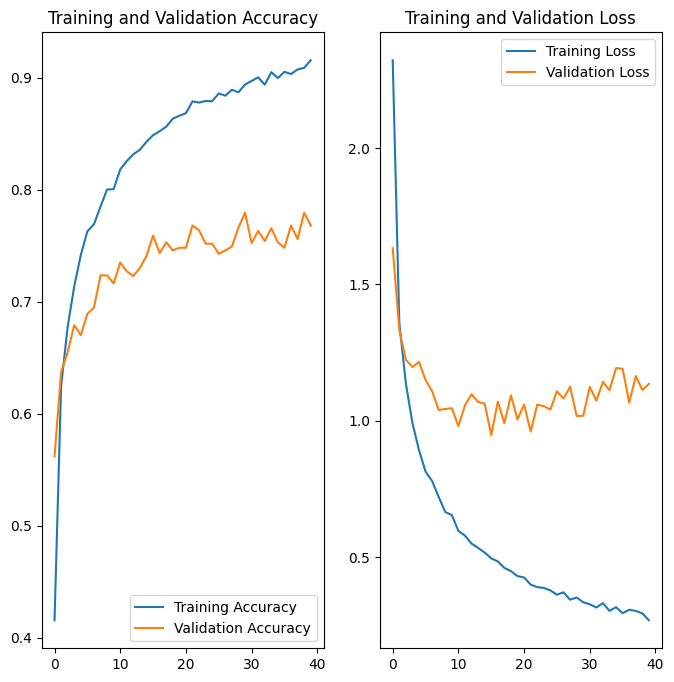

In [41]:
import matplotlib.pyplot as plt

EPOCHS = 40

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

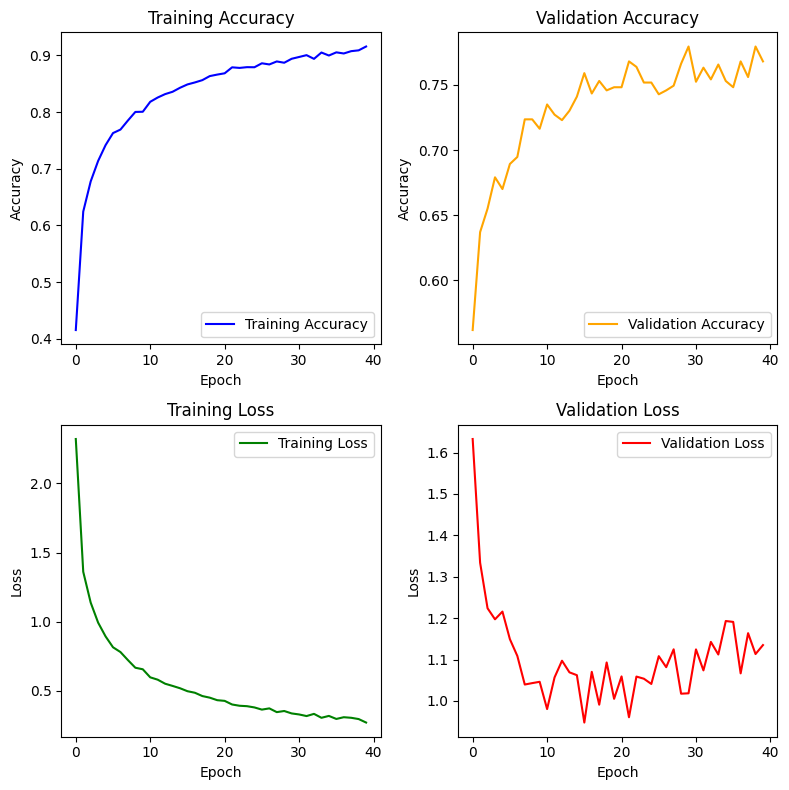

In [42]:
import matplotlib.pyplot as plt

EPOCHS = 40

# Plot Training Accuracy
plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Training Loss
plt.subplot(2, 2, 3)
plt.plot(range(EPOCHS), loss, label='Training Loss', color='green')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot Validation Loss
plt.subplot(2, 2, 4)
plt.plot(range(EPOCHS), val_loss, label='Validation Loss', color='red')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

First image to predict
Actual label: Solanum incanum
1/1 [==============================] - 1s 1s/step
Predicted label: Solanum incanum


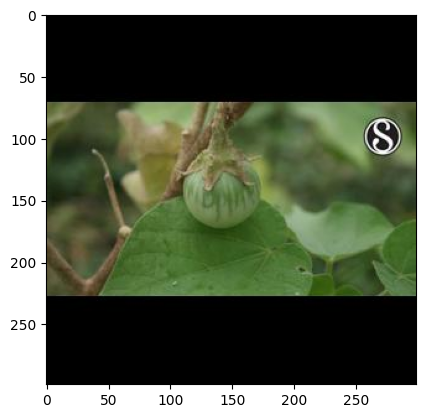

In [43]:
import numpy as np

for images_batch, labels_batch in test_generator:
   
    first_image = images_batch[0]
    first_label = np.argmax(labels_batch[0])  # Use np.argmax to get the class index

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])

    batch_predictions = model.predict(images_batch)
    predicted_label = class_names[np.argmax(batch_predictions[0])]  # Use np.argmax for categorical class mode
    print("Predicted label:", predicted_label)

    break

1/1 [==============================] - 0s 30ms/step


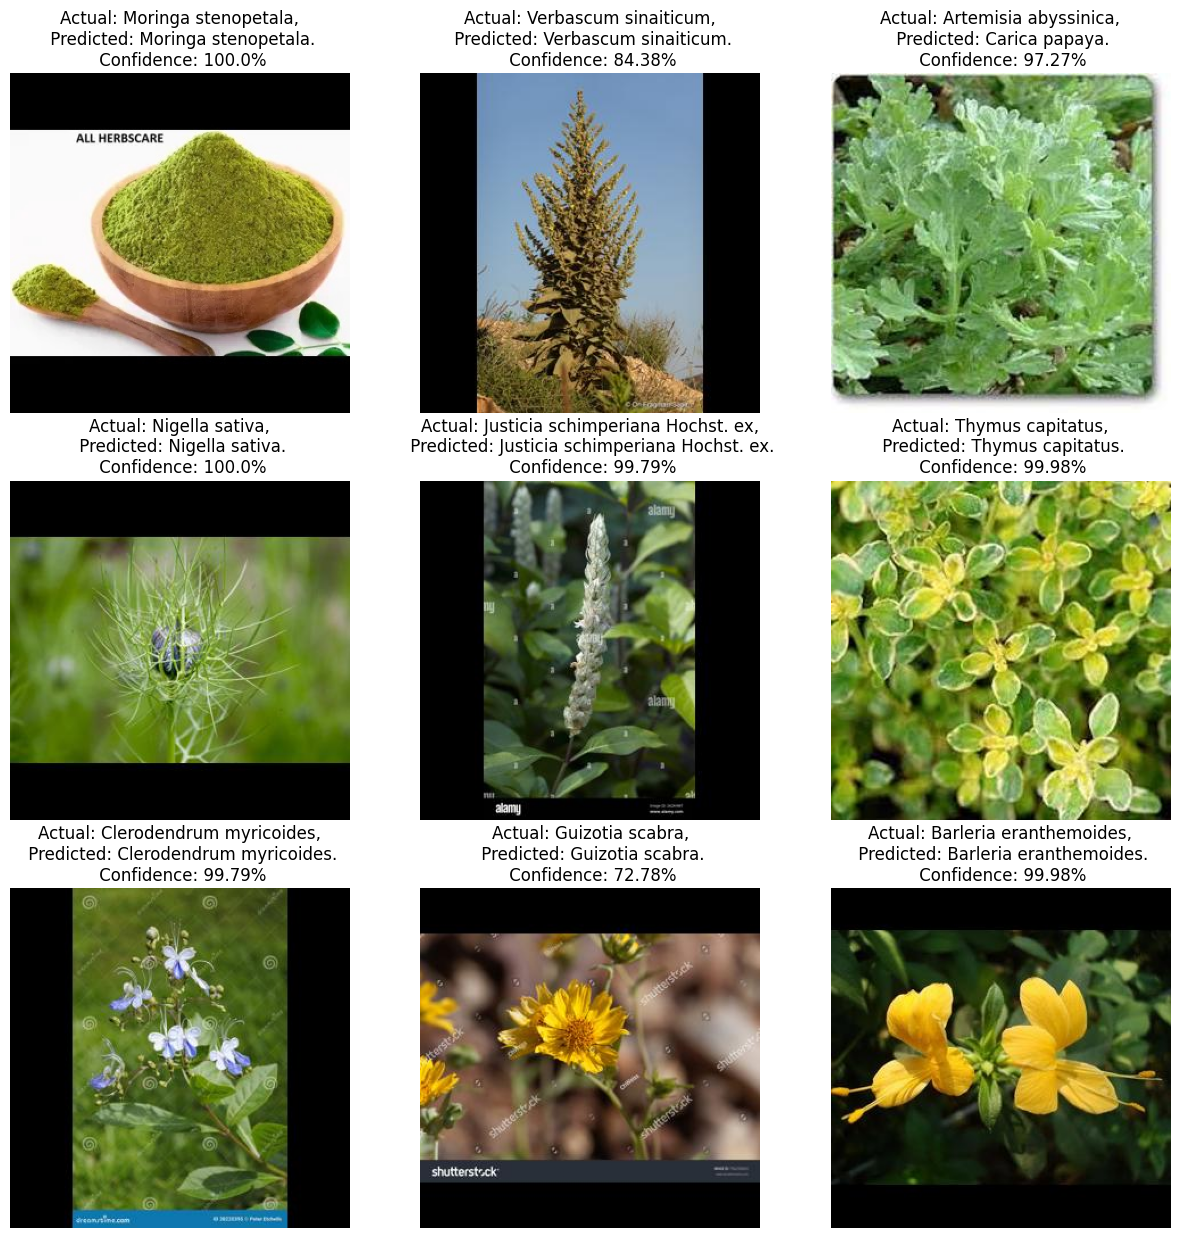

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[np.argmax(labels[i])]  # Access class_names using np.argmax

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
    break

1/1 [==============================] - 0s 31ms/step


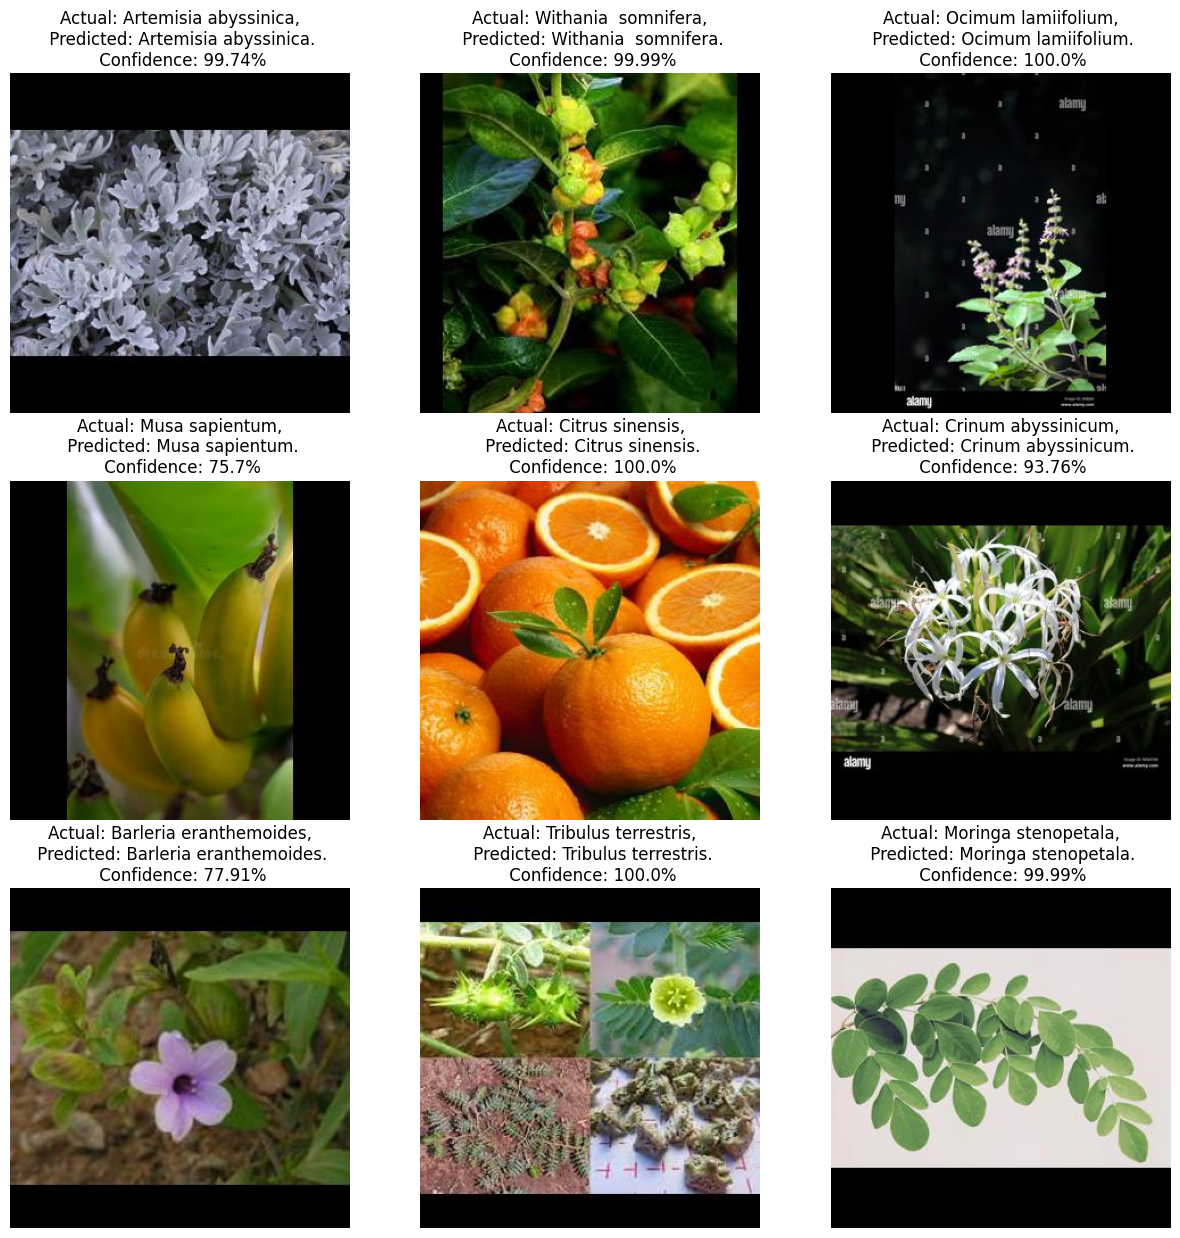

In [51]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[np.argmax(labels[i])]  # Access class_names using np.argmax

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
    break

In [52]:
model.save("saved_models/TrainedModel3_InceptionV3X.h5")

In [53]:
model.save("saved_models/TrainedModel3_InceptionV3X.keras")

In [54]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("saved_models/TrainedModel3_InceptionV3X.tflite", 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpgghh5y_s/assets


INFO:tensorflow:Assets written to: /tmp/tmpgghh5y_s/assets
2024-01-16 20:39:08.532941: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-01-16 20:39:08.532979: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-01-16 20:39:08.744200: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2024-01-16 20:39:09.471263: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgghh5y_s
2024-01-16 20:39:09.693096: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 1159292 microseconds.
